# 📊 Price Plan Recommendation — High-Silhouette & Safe Billing (IPYNB)


This notebook is tuned to:
- Improve **silhouette** using **MinMaxScaler** and optional **PCA**
- Prevent **negative bills** via share normalization and safe clipping
- Deliver **Top‑3 plan recommendations** with ≤25 plans


## 0) Setup & Load

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PATH = Path(r"C:\CTS Hackathon\Price_Plan_Recommendation-main\Price_Plan_Recommendation-main\data\raw\cdr_dataset.csv")
df = pd.read_csv(DATA_PATH).copy()

def normalize(col: str) -> str:
    return col.strip().lower().replace(" ", "_").replace("-", "_").replace(".", "_")
df.rename(columns={c: normalize(c) for c in df.columns}, inplace=True)

print("Loaded shape:", df.shape)
df.head(3)


Loaded shape: (101174, 17)


,phone_number,account_length,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,382-4657,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,371-7191,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,358-1921,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


In [1]:
import sys
print(sys.executable)

c:\CTS Hackathon\Price_Plan_Recommendation-main\.venv\Scripts\python.exe


## 1) Preprocess & Feature Engineering

In [4]:
aliases = {
    "account_length": ["account_length"],
    "vmail_message": ["vmail_message","voice_mail_messages","voicemail_message"],
    "international_plan": ["international_plan","intl_plan"],
    "voice_mail_plan": ["voice_mail_plan","voicemail_plan"],
    "custserv_calls": ["custserv_calls","customer_service_calls"],
    "day_mins": ["day_mins","total_day_minutes"],
    "eve_mins": ["eve_mins","total_eve_minutes"],
    "night_mins": ["night_mins","total_night_minutes"],
    "intl_mins": ["intl_mins","total_intl_minutes"],
    "day_calls": ["day_calls","total_day_calls"],
    "eve_calls": ["eve_calls","total_eve_calls"],
    "night_calls": ["night_calls","total_night_calls"],
    "intl_calls": ["intl_calls","total_intl_calls"],
    "day_charge": ["day_charge","total_day_charge"],
    "eve_charge": ["eve_charge","total_eve_charge"],
    "night_charge": ["night_charge","total_night_charge"],
    "intl_charge": ["intl_charge","total_intl_charge"],
}

def pick(name):
    for c in aliases.get(name, []):
        if c in df.columns:
            return c
    return None

canonical_map = {k: pick(k) for k in aliases.keys()}

mins_cols   = [canonical_map[c] for c in ["day_mins","eve_mins","night_mins","intl_mins"] if canonical_map.get(c)]
calls_cols  = [canonical_map[c] for c in ["day_calls","eve_calls","night_calls","intl_calls"] if canonical_map.get(c)]
charge_cols = [canonical_map[c] for c in ["day_charge","eve_charge","night_charge","intl_charge"] if canonical_map.get(c)]

if mins_cols:   df["total_mins"]   = df[mins_cols].sum(axis=1)
if calls_cols:  df["total_calls"]  = df[calls_cols].sum(axis=1)
if charge_cols: df["total_charge"] = df[charge_cols].sum(axis=1)

# Shares
if "total_mins" in df.columns:
    for part in ["day","eve","night","intl"]:
        col = canonical_map.get(f"{part}_mins")
        if col:
            df[f"{part}_mins_share"] = df[col] / df["total_mins"].replace(0, np.nan)

# Avg mins per call
if {"total_mins","total_calls"}.issubset(df.columns):
    df["avg_mins_per_call"] = df["total_mins"] / df["total_calls"].replace(0, np.nan)

print("Engineered shape:", df.shape)
df.head(3)


Engineered shape: (101174, 25)


,phone_number,account_length,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,...,custserv_calls,churn,total_mins,total_calls,total_charge,day_mins_share,eve_mins_share,night_mins_share,intl_mins_share,avg_mins_per_call
0,382-4657,128,25,265.1,110,45.07,197.4,99,16.78,244.7,...,1,False,717.2,303,75.56,0.369632,0.275237,0.341188,0.013943,2.366997
1,371-7191,107,26,161.6,123,27.47,195.5,103,16.62,254.4,...,1,False,625.2,332,59.24,0.258477,0.312700,0.406910,0.021913,1.883133
2,358-1921,137,0,243.4,114,41.38,121.2,110,10.30,162.6,...,0,False,539.4,333,62.29,0.451242,0.224694,0.301446,0.022618,1.619820


## 2) Data Cleaning (duplicates, missing, outliers)

In [5]:
before = len(df)

# Keep only unique phone numbers (drop duplicates)
if "phone_number" in df.columns:
    df = df.drop_duplicates(subset=["phone_number"], keep="first")  # keep first occurrence
    print(f"Removed duplicates based on phone_number: {before - len(df)} rows")
else:
    df = df.drop_duplicates()
    print(f"Removed exact duplicate rows: {before - len(df)}")

# Fill missing values with 0
df = df.fillna(0)

# Remove outliers (IQR method) from key usage columns
for col in ["total_mins", "total_calls", "total_charge"]:
    if col in df.columns:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        before_out = len(df)
        df = df[(df[col] >= lower) & (df[col] <= upper)]
        print(f"Removed {before_out - len(df)} outliers from {col}")

print("Final dataset shape:", df.shape)


Removed duplicates based on phone_number: 93707 rows
Removed 0 outliers from total_mins
Removed 400 outliers from total_calls
Removed 0 outliers from total_charge
Final dataset shape: (7067, 25)


## 3) Scaling (MinMax) + Optional PCA 

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

features = [
    canonical_map.get("account_length"),
    canonical_map.get("vmail_message"),
    "total_mins","total_calls",
    "day_mins_share","eve_mins_share","night_mins_share","intl_mins_share",
    canonical_map.get("custserv_calls"),
]
features = [f for f in features if f is not None]
X = df[features].astype(float).fillna(0)

share_cols = ["day_mins_share","eve_mins_share","night_mins_share","intl_mins_share"]
if all(c in X.columns for c in share_cols):
    S = X[share_cols].sum(axis=1).replace(0, 1.0)
    for c in share_cols:
        X[c] = np.clip(X[c] / S, 0, 1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

USE_PCA = True
PCA_COMPONENTS = 6
if USE_PCA:
    pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
    X_for_cluster = pca.fit_transform(X_scaled)
    print("PCA variance:", np.round(pca.explained_variance_ratio_, 3))
else:
    pca = None
    X_for_cluster = X_scaled


PCA variance: [0.418 0.205 0.126 0.068 0.064 0.053]


## 4) Silhouette Scan

Silhouette scores: {4: 0.429, 5: 0.385, 6: 0.402, 7: 0.286, 8: 0.269, 9: 0.257, 10: 0.266}


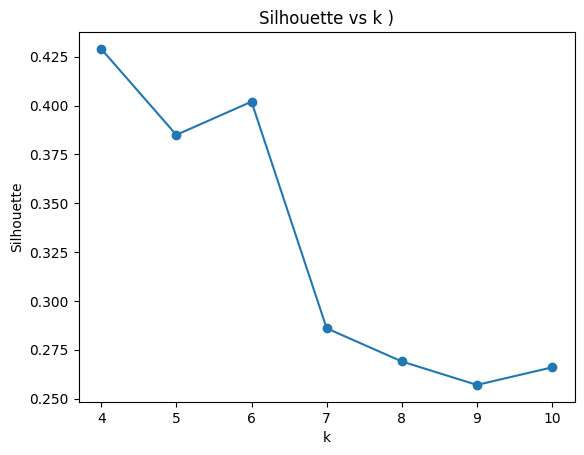

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sil_scores = {}
for k in range(4, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_for_cluster)
    sil_scores[k] = round(silhouette_score(X_for_cluster, labels), 3)

print("Silhouette scores:", sil_scores)

plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette vs k )")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()


## 5) Final Kmeans

In [8]:
AUTO_PICK_BEST = False
best_k = max(sil_scores, key=sil_scores.get) if AUTO_PICK_BEST else 6
print("Using k =", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
df["Cluster"] = kmeans.fit_predict(X_for_cluster)

final_sil = silhouette_score(X_for_cluster, df["Cluster"])
print(f"Silhouette (final, k={best_k}): {final_sil:.3f}")


Using k = 6
Silhouette (final, k=6): 0.402


## 6) Profiling

In [9]:
## Cluster profiling for k=6
profile_cols = [
    "total_mins","total_calls","total_charge",
    "day_mins_share","eve_mins_share","night_mins_share","intl_mins_share",
    "avg_mins_per_call"
]
cluster_profile = df.groupby("Cluster")[profile_cols].mean().round(3)
sizes = df["Cluster"].value_counts().sort_index().rename("size")
cluster_profile = pd.concat([sizes, cluster_profile], axis=1)

print("Cluster profiles (k=6):")
cluster_profile


Cluster profiles (k=6):


,size,total_mins,total_calls,total_charge,day_mins_share,eve_mins_share,night_mins_share,intl_mins_share,avg_mins_per_call
Cluster,,,,,,,,,
0,3355,629.340,337.392,61.007,0.305,0.338,0.338,0.019,1.993
1,854,1370.473,736.317,118.302,0.315,0.334,0.331,0.020,2.186
2,922,1355.684,723.034,116.097,0.313,0.330,0.336,0.021,2.250
3,340,1370.241,737.668,118.489,0.317,0.334,0.329,0.020,2.169
4,356,1370.143,708.365,120.137,0.313,0.331,0.335,0.021,2.332
5,1240,626.437,336.732,61.011,0.304,0.339,0.338,0.018,1.991


## 7) Plan Catalog

In [10]:
def mk_plan(name, monthly_rental, local_rate, night_rate, eve_rate, intl_rate,
            free_day=0, free_night=0, free_eve=0, free_intl=0):
    return {
        "plan_name": name,
        "monthly_rental": monthly_rental,
        "rate_local_day": local_rate,
        "rate_local_eve": eve_rate,
        "rate_local_night": night_rate,
        "rate_intl": intl_rate,
        "free_day": free_day,
        "free_eve": free_eve,
        "free_night": free_night,
        "free_intl": free_intl,
    }

catalog_specs = [
    # Light Talkers (Cluster ~low mins)
    ("Lite Voice 99",      99, 0.20, 0.12, 0.12, 0.35, 100, 50, 50, 0),
    ("Lite Value 149",    149, 0.18, 0.10, 0.10, 0.32, 200,100,100,0),

    # Day Users
    ("Day Saver 249",     249, 0.15, 0.10, 0.09, 0.28, 500,100,100,0),
    ("Day Pro 349",       349, 0.14, 0.10, 0.09, 0.27, 800,150,150,0),

    # Night Owls
    ("Night Owl 199",     199, 0.18, 0.05, 0.12, 0.32,  50,800,100,0),
    ("Midnight Max 299",  299, 0.17, 0.00, 0.12, 0.30, 100,1500,200,0),

    # Balanced Users
    ("All-Rounder 299",   299, 0.16, 0.08, 0.08, 0.28, 300,300,300,10),
    ("All-Rounder Pro 399",399,0.15, 0.08, 0.08, 0.27, 400,400,400,20),

    # Heavy Talkers
    ("Unlimited Talk 399",399, 0.14, 0.07, 0.07, 0.28, 900,600,600,0),
    ("Ultra Unlimited 499",499,0.13, 0.06, 0.07, 0.26,1200,800,800,0),

    # Global Users
    ("Global Saver 399",  399, 0.16, 0.08, 0.08, 0.23, 300,200,200,50),
    ("Global Connect 599",599, 0.15, 0.08, 0.08, 0.20, 500,300,300,100),
]

catalog = [mk_plan(*spec) for spec in catalog_specs]
catalog_df = pd.DataFrame(catalog)

print("Total plans:", len(catalog_df))
catalog_df


Total plans: 12


,plan_name,monthly_rental,rate_local_day,rate_local_eve,rate_local_night,rate_intl,free_day,free_eve,free_night,free_intl
0,Lite Voice 99,99,0.20,0.12,0.12,0.35,100,50,50,0
1,Lite Value 149,149,0.18,0.10,0.10,0.32,200,100,100,0
2,Day Saver 249,249,0.15,0.09,0.10,0.28,500,100,100,0
3,Day Pro 349,349,0.14,0.09,0.10,0.27,800,150,150,0
4,Night Owl 199,199,0.18,0.12,0.05,0.32,50,100,800,0
5,Midnight Max 299,299,0.17,0.12,0.00,0.30,100,200,1500,0
6,All-Rounder 299,299,0.16,0.08,0.08,0.28,300,300,300,10
7,All-Rounder Pro 399,399,0.15,0.08,0.08,0.27,400,400,400,20
8,Unlimited Talk 399,399,0.14,0.07,0.07,0.28,900,600,600,0
9,Ultra Unlimited 499,499,0.13,0.07,0.06,0.26,1200,800,800,0


## 8) Billing and Recommendation

Available columns in customer dataframe: ['phone_number', 'account_length', 'vmail_message', 'day_mins', 'day_calls', 'day_charge', 'eve_mins', 'eve_calls', 'eve_charge', 'night_mins', 'night_calls', 'night_charge', 'intl_mins', 'intl_calls', 'intl_charge', 'custserv_calls', 'churn', 'total_mins', 'total_calls', 'total_charge', 'day_mins_share', 'eve_mins_share', 'night_mins_share', 'intl_mins_share', 'avg_mins_per_call', 'Cluster']

Plan Distribution Analysis:
--------------------------------------------------

Recommendations per plan:
plan_name
All-Rounder 299        6796
Lite Value 149         4427
Unlimited Talk 399     2780
Day Saver 249          2261
Ultra Unlimited 499    2238
Night Owl 199          2192
All-Rounder Pro 399     257
Midnight Max 299        194
Day Pro 349              55
Global Saver 399          1
Name: count, dtype: int64


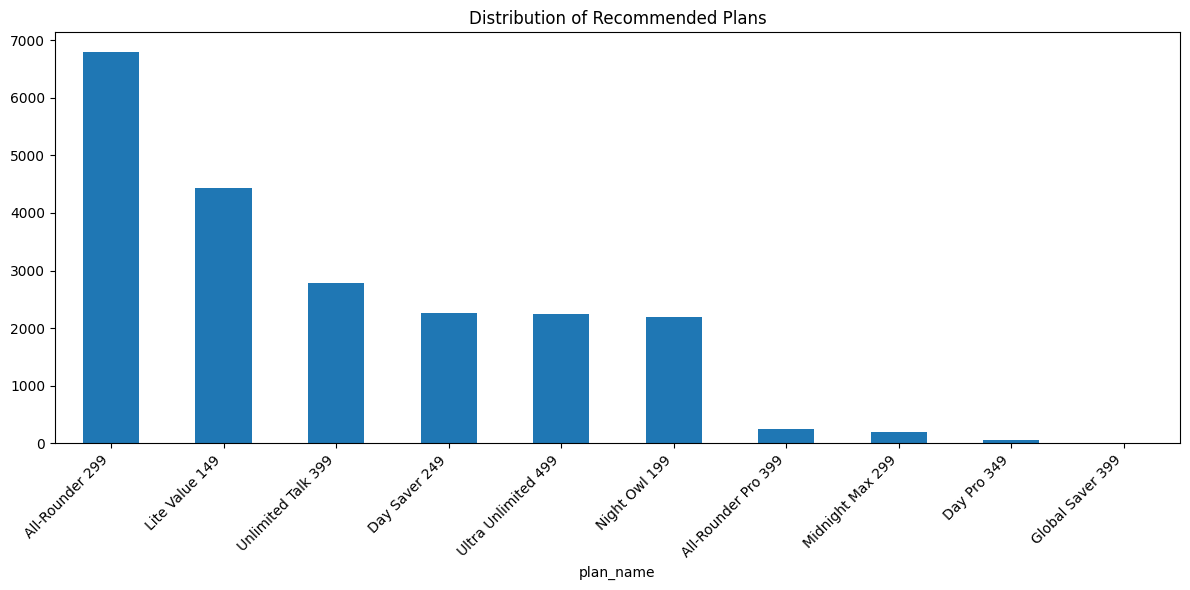


Sample Recommendations:
   index     phone  cluster        plan_name     category  estimated_cost  \
0      0  382-4657        5  All-Rounder 299  All-Rounder          299.00   
1      0  382-4657        5   Lite Value 149         Lite          188.13   
2      0  382-4657        5    Day Saver 249          Day          275.04   
3      1  371-7191        5  All-Rounder 299  All-Rounder          300.04   
4      1  371-7191        5   Lite Value 149         Lite          178.37   
5      1  371-7191        5    Night Owl 199        Night          234.93   
6      2  358-1921        0   Lite Value 149         Lite          169.10   
7      2  358-1921        0  All-Rounder 299  All-Rounder          299.62   
8      2  358-1921        0    Day Saver 249          Day          260.58   
9      3  375-9999        0   Lite Value 149         Lite          178.69   

   suitability  final_score  rank  
0        0.680        0.691     1  
1        0.518        0.665     2  
2        0.558     

In [15]:
# =============================
# Enhanced Billing + Recommendations (Fixed)
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def safe_normalize_shares(row):
    """Safely normalize usage shares"""
    keys = ["day_mins_share", "eve_mins_share", "night_mins_share", "intl_mins_share"]
    vals = [max(0, float(row.get(k, 0))) for k in keys]
    s = sum(vals)
    return dict(zip(keys, [0.25, 0.25, 0.25, 0.25] if s <= 0 else [v/s for v in vals]))

def estimate_bill(row, plan):
    """Calculate estimated bill with safeguards"""
    try:
        total = max(row.get("total_mins", 0), 0)
        shares = safe_normalize_shares(row)
        
        # Calculate minutes for each period
        d = shares["day_mins_share"] * total
        e = shares["eve_mins_share"] * total
        n = shares["night_mins_share"] * total
        intl = shares["intl_mins_share"] * total
        
        # Calculate billable minutes (after free minutes)
        d_bill = max(d - float(plan["free_day"]), 0)
        e_bill = max(e - float(plan["free_eve"]), 0)
        n_bill = max(n - float(plan["free_night"]), 0)
        i_bill = max(intl - float(plan["free_intl"]), 0)
        
        # Calculate variable charges
        variable = (
            d_bill * float(plan["rate_local_day"]) +
            e_bill * float(plan["rate_local_eve"]) +
            n_bill * float(plan["rate_local_night"]) +
            i_bill * float(plan["rate_intl"])
        )
        
        return round(float(plan["monthly_rental"]) + variable, 2)
    except Exception as e:
        print(f"Warning: Billing calculation error - {str(e)}")
        return float(plan["monthly_rental"])

def calculate_plan_suitability(row, plan):
    """Calculate plan suitability score (0-1)"""
    try:
        # Get usage patterns
        total = max(row.get("total_mins", 0), 0)
        shares = safe_normalize_shares(row)
        
        # Time distribution match (40%)
        time_match = 1 - sum([
            abs(shares["day_mins_share"] - (plan["free_day"] / (plan["free_day"] + plan["free_eve"] + plan["free_night"]))),
            abs(shares["eve_mins_share"] - (plan["free_eve"] / (plan["free_day"] + plan["free_eve"] + plan["free_night"]))),
            abs(shares["night_mins_share"] - (plan["free_night"] / (plan["free_day"] + plan["free_eve"] + plan["free_night"])))
        ]) / 2
        
        # Usage volume match (30%)
        total_free = plan["free_day"] + plan["free_eve"] + plan["free_night"]
        volume_match = min(1.0, total_free / max(total, 1))
        
        # Special features match (30%)
        special_score = 0.0
        if shares["intl_mins_share"] > 0.05 and plan["free_intl"] > 0:
            special_score += 0.5
        if total > 800 and total_free > 800:
            special_score += 0.5
            
        # Final weighted score
        final_score = (
            0.4 * time_match +
            0.3 * volume_match +
            0.3 * special_score
        )
        
        return round(float(np.clip(final_score, 0, 1)), 3)
    except Exception as e:
        print(f"Warning: Suitability calculation error - {str(e)}")
        return 0.0

def recommend_plans(row, catalog_df, n_recommendations=3):
    """Generate diverse plan recommendations"""
    try:
        recommendations = []
        
        # Calculate scores for all plans
        for _, plan in catalog_df.iterrows():
            monthly_cost = estimate_bill(row, plan)
            suitability = calculate_plan_suitability(row, plan)
            
            # Get plan category and price tier
            category = plan["plan_name"].split()[0]
            price_tier = (
                'Budget' if plan["monthly_rental"] < 250 
                else 'Premium' if plan["monthly_rental"] > 400 
                else 'Standard'
            )
            
            recommendations.append({
                "plan_name": plan["plan_name"],
                "category": category,
                "price_tier": price_tier,
                "monthly_cost": monthly_cost,
                "suitability": suitability,
                "final_score": round(0.5 * (1 - monthly_cost/1000) + 0.5 * suitability, 3)
            })
        
        # Convert to DataFrame for easier handling
        recs_df = pd.DataFrame(recommendations)
        
        # Select diverse recommendations
        final_recs = []
        categories_used = set()
        
        # First get the absolute best match
        best = recs_df.nlargest(1, "final_score").iloc[0]
        final_recs.append(best)
        categories_used.add(best["category"])
        
        # Then get plans from different categories
        remaining = recs_df[~recs_df["category"].isin(categories_used)]
        while len(final_recs) < n_recommendations and not remaining.empty:
            next_best = remaining.nlargest(1, "final_score").iloc[0]
            final_recs.append(next_best)
            categories_used.add(next_best["category"])
            remaining = recs_df[~recs_df["category"].isin(categories_used)]
        
        # If we still need more, take best remaining
        remaining = recs_df[~recs_df["plan_name"].isin([r["plan_name"] for r in final_recs])]
        while len(final_recs) < n_recommendations and not remaining.empty:
            next_best = remaining.nlargest(1, "final_score").iloc[0]
            final_recs.append(next_best)
            remaining = remaining[remaining["plan_name"] != next_best["plan_name"]]
        
        return final_recs
        
    except Exception as e:
        print(f"Warning: Recommendation error - {str(e)}")
        return []

# FIX: Check what phone column actually exists in the dataset
# First, let's check what columns are available in the customer dataframe
print("Available columns in customer dataframe:", list(df.columns))

# Find the actual phone column name
phone_col = None
possible_phone_cols = ['phone', 'phone_number', 'Phone', 'Phone_Number', 'PHONE']
for col in possible_phone_cols:
    if col in df.columns:
        phone_col = col
        break

if phone_col is None:
    print("Warning: No phone column found. Using index as identifier.")
    phone_col = None

# Generate recommendations for all customers
recs = []
for idx, row in df.iterrows():
    try:
        recommendations = recommend_plans(row, catalog_df)
        
        # Get phone number or use index as fallback
        if phone_col:
            phone = str(row[phone_col]).strip()
        else:
            phone = f"Customer_{idx}"
        
        for rank, rec in enumerate(recommendations, 1):
            recs.append({
                "index": idx,
                "phone": phone,
                "cluster": int(row["Cluster"]),
                "plan_name": rec["plan_name"],
                "category": rec["category"],
                "estimated_cost": round(rec["monthly_cost"], 2),
                "suitability": rec["suitability"],
                "final_score": rec["final_score"],
                "rank": rank
            })
    except Exception as e:
        print(f"Warning: Error processing customer {idx} - {str(e)}")
        continue

# Create recommendations DataFrame
if recs:  # Only proceed if we have recommendations
    recs_df = pd.DataFrame(recs)

    # Analyze plan distribution
    print("\nPlan Distribution Analysis:")
    print("-" * 50)
    plan_dist = recs_df["plan_name"].value_counts()
    print("\nRecommendations per plan:")
    print(plan_dist)

    # Visualize distribution
    plt.figure(figsize=(12, 6))
    plan_dist.plot(kind='bar')
    plt.title('Distribution of Recommended Plans')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Display sample recommendations
    print("\nSample Recommendations:")
    print(recs_df.head(10))
else:
    print("No recommendations were generated. Please check the input data.")

In [17]:
import joblib, json
from pathlib import Path
OUT_DIR_M = Path(r"C:\CTS Hackathon\Price_Plan_Recommendation-main\Price_Plan_Recommendation-main\data\processed")
OUT_DIR = Path(r"C:\CTS Hackathon\Price_Plan_Recommendation-main\Price_Plan_Recommendation-main\data\processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Save datasets ---
df.to_csv(OUT_DIR / "customers_with_clusters.csv", index=False)
recs_df.to_csv(OUT_DIR / "top3_recommendations_ph.csv", index=False)
catalog_df.to_csv(OUT_DIR / "plan_catalog.csv", index=False)

print("✅ Datasets saved:")
print(" - customers_with_clusters.csv")
print(" - top3_recommendations.csv")
print(" - plan_catalog.csv")

# --- Save model pipeline ---
model_bundle = {
    "features": features,
    "share_cols": share_cols,
    "scaler": scaler,
    "pca": pca,
    "kmeans": kmeans,
}

MODEL_PATH = OUT_DIR_M / "model.pkl"
joblib.dump(model_bundle, MODEL_PATH)

with open(OUT_DIR / "model_features.json", "w") as f:
    json.dump({"features": features, "share_cols": share_cols}, f, indent=2)

print("✅ Model saved:")
print(" -", MODEL_PATH)
print(" - model_features.json")


✅ Datasets saved:
 - customers_with_clusters.csv
 - top3_recommendations.csv
 - plan_catalog.csv
✅ Model saved:
 - C:\CTS Hackathon\Price_Plan_Recommendation-main\Price_Plan_Recommendation-main\data\processed\model.pkl
 - model_features.json
